In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

nltk.download('stopwords')
nltk.download('ignore')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Error loading ignore: Package 'ignore' not found in index
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
df=pd.read_csv('Hate-Speech-Detection-Dataset.csv')
df.head()

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [4]:
df.shape

(24783, 2)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   class   24783 non-null  int64 
 1   tweet   24783 non-null  object
dtypes: int64(1), object(1)
memory usage: 387.4+ KB


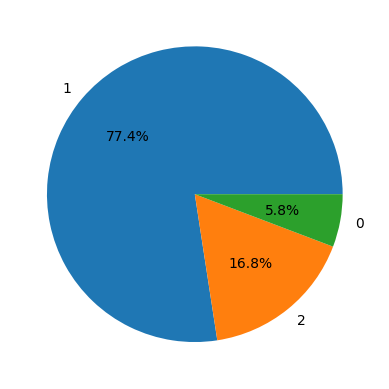

In [6]:
plt.pie(df['class'].value_counts().values,
        labels=df['class'].value_counts().index,
        autopct='%1.1f%%')

plt.show()



*   0 - Hate Speech
*   1 - Offensive language
*   2 - Neither


In [25]:
df['tweet']=df['tweet'].apply(lambda x : x.lower())
df['tweet']=df['tweet'].apply(lambda x : re.sub('[^a-zA-Z]',' ',x))


In [26]:
wd=WordNetLemmatizer()
def preprocessing(text):
  review=text.split()
  review=[wd.lemmatize(word) for word in review if not word in set(stopwords.words('english'))]
  review=' '.join(review)
  return review


In [27]:
df['tweet']=df['tweet'].apply(lambda x : preprocessing(x))

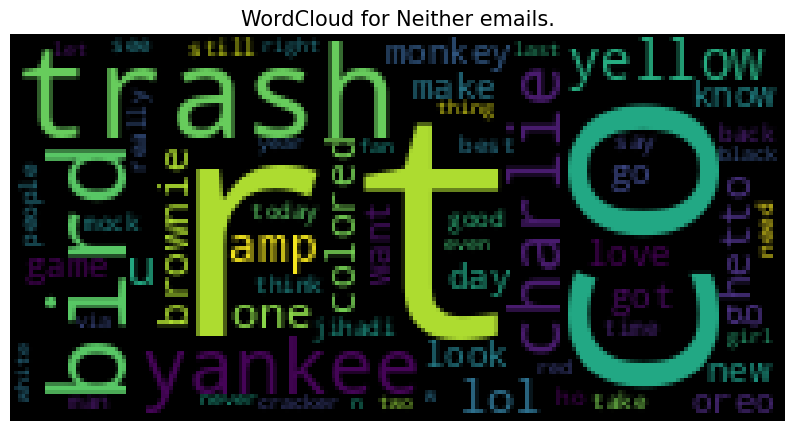

In [34]:
def plot_word_cloud(data, typ):
  email_corpus = " ".join(data['tweet'])
  plt.figure(figsize = (10,10))

  wc = WordCloud(max_words = 100,
                width = 200,
                height = 100,
                collocations = False).generate(email_corpus)

  plt.title(f'WordCloud for {typ} emails.', fontsize = 15)
  plt.axis('off')
  plt.imshow(wc)
  plt.show()
  print()

plot_word_cloud(df[df['class']==2], typ='Neither')


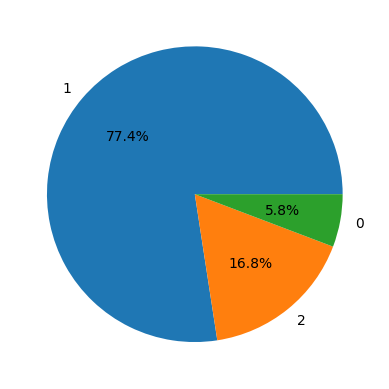

In [37]:
plt.pie(df['class'].value_counts().values,
        labels=df['class'].value_counts().index,
        autopct='%1.1f%%')
plt.show()


In [38]:
class_2 = df[df['class'] == 2]
class_1 = df[df['class'] == 1].sample(n=3500)
class_0 = df[df['class'] == 0]

balanced_df = pd.concat([class_0, class_0, class_0, class_1, class_2], axis=0)


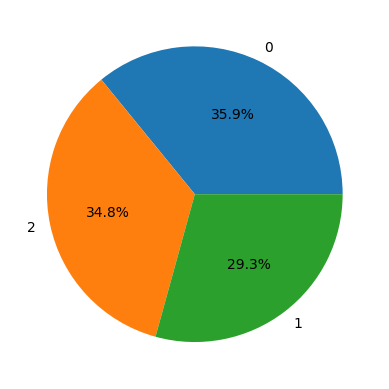

In [39]:
plt.pie(balanced_df['class'].value_counts().values,
        labels=balanced_df['class'].value_counts().index,
        autopct='%1.1f%%')
plt.show()


In [41]:
x=balanced_df['tweet']
y=balanced_df['class']

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

x_train.shape,x_test.shape

((9562,), (2391,))

In [46]:
y_train

,class
4723,2
19470,2
11616,1
22078,2
8419,2
...,...
20501,2
6441,1
7717,1
12052,0


In [64]:
Y_train = pd.get_dummies(y_train)
Y_test = pd.get_dummies(y_test)
Y_train.shape, Y_test.shape


((9562, 3), (2391, 3))

In [65]:
Y_train

,0,1,2
4723,False,False,True
19470,False,False,True
11616,False,True,False
22078,False,False,True
8419,False,False,True
...,...,...,...
20501,False,False,True
6441,False,True,False
7717,False,True,False
12052,True,False,False


In [70]:
max_words = 5000
max_len = 100

token= Tokenizer(num_words=max_words,
                 lower=True,
                 split=' ')

token.fit_on_texts(x_train)

In [72]:
max_words = 5000
token = Tokenizer(num_words=max_words,
				lower=True,
				split=' ')
token.fit_on_texts(x_train)

training_seq= token.texts_to_sequences(x_train)
training_pad= pad_sequences(training_seq,
                            maxlen=50,
                            padding='post',
                            truncating='post')

testing_seq=token.texts_to_sequences(x_test)
testing_pad=pad_sequences(training_seq,
                          maxlen=50,
                          padding='post',
                          truncating='post')

In [82]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,BatchNormalization,Dropout,Bidirectional,Embedding

Model=Sequential([
    Embedding(max_words,32,input_shape=(max_len,)),
    Bidirectional(LSTM(16)),
    Dense(512,activation='relu',kernel_regularizer='l1'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(3,activation='softmax')
])

Model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
Model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 100, 32)        │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 32)             │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 186,755 (729.51 KB)

 Trainable params: 185,731 (725.51 KB)

 Non-trainable params: 1,024 (4.00 KB)

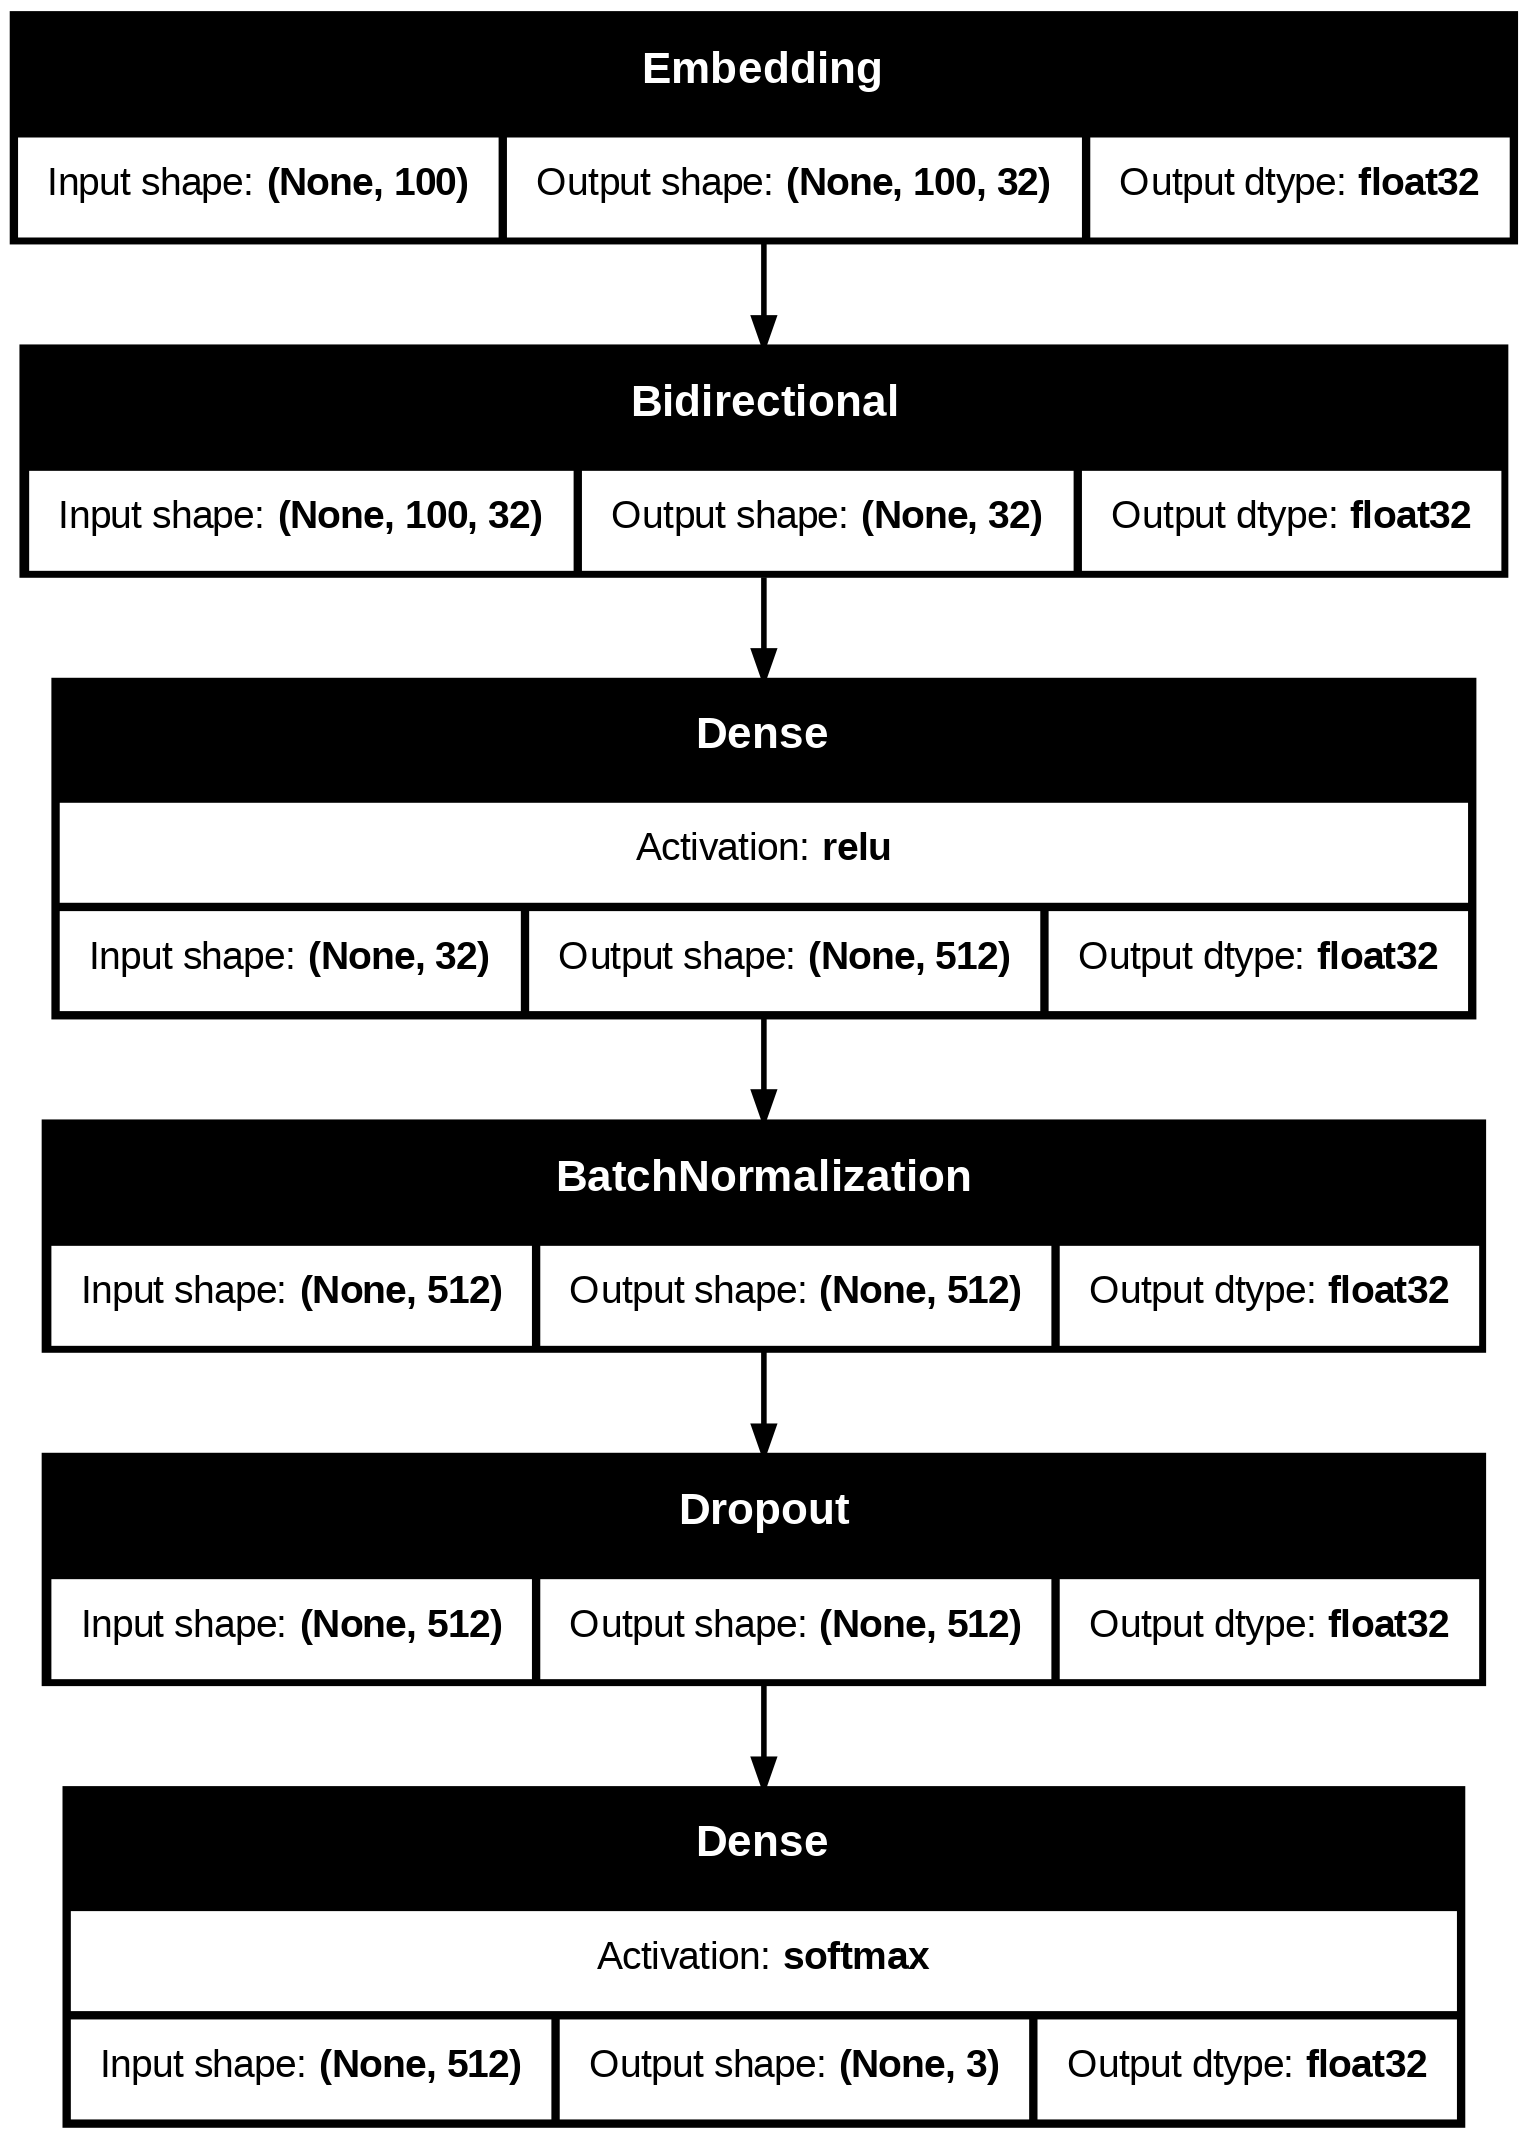

In [83]:
from tensorflow.keras.utils import plot_model
Model.build((None, max_len))

plot_model(
    Model,
    show_shapes=True,
    show_dtype=True,
    show_layer_activations=True
)


In [84]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

es = EarlyStopping(patience=3,
                   monitor = 'val_accuracy',
                   restore_best_weights = True)

lr = ReduceLROnPlateau(patience = 2,
                       monitor = 'val_loss',
                       factor = 0.5,
                       verbose = 0)


In [86]:
tokenizer = Tokenizer(num_words=max_words)

tokenizer.fit_on_texts(x_train)

X_train_seq = tokenizer.texts_to_sequences(x_train)
X_val_seq = tokenizer.texts_to_sequences(x_test)

from tensorflow.keras.utils import pad_sequences
X_train_padded = pad_sequences(X_train_seq, maxlen=max_len)
X_val_padded = pad_sequences(X_val_seq, maxlen=max_len)



In [87]:
history = Model.fit(X_train_padded, Y_train,
					validation_data=(X_val_padded, Y_test),
					epochs=50,
					verbose=1,
					batch_size=32,
					callbacks=[lr, es])


Epoch 1/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 24s 62ms/step - accuracy: 0.7027 - loss: 3.7993 - val_accuracy: 0.4245 - val_loss: 1.0314 - learning_rate: 0.0010
Epoch 2/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 21s 65ms/step - accuracy: 0.9148 - loss: 0.3484 - val_accuracy: 0.8524 - val_loss: 0.5092 - learning_rate: 0.0010
Epoch 3/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 19s 60ms/step - accuracy: 0.9380 - loss: 0.2587 - val_accuracy: 0.8720 - val_loss: 0.4623 - learning_rate: 0.0010
Epoch 4/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 22s 74ms/step - accuracy: 0.9555 - loss: 0.2021 - val_accuracy: 0.8197 - val_loss: 0.6938 - learning_rate: 0.0010
Epoch 5/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 37s 62ms/step - accuracy: 0.9622 - loss: 0.1814 - val_accuracy: 0.8850 - val_loss: 0.5622 - learning_rate: 0.0010
Epoch 6/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 21s 64ms/step - accuracy: 0.9788 - loss: 0.1133 - val_accuracy: 0.8959 - val_loss: 0.4654 - learning_rate: 5.0000e-04
Epoch 7/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 19s 59ms/step - accuracy: 0.9822

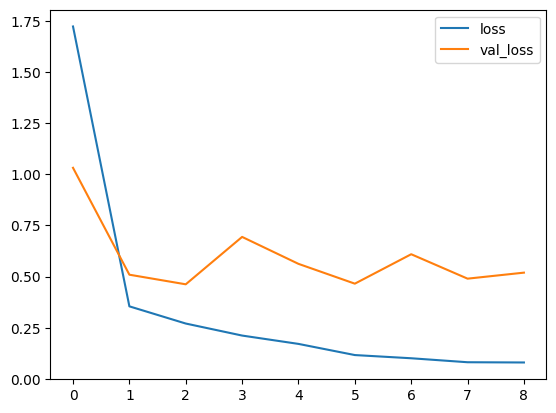

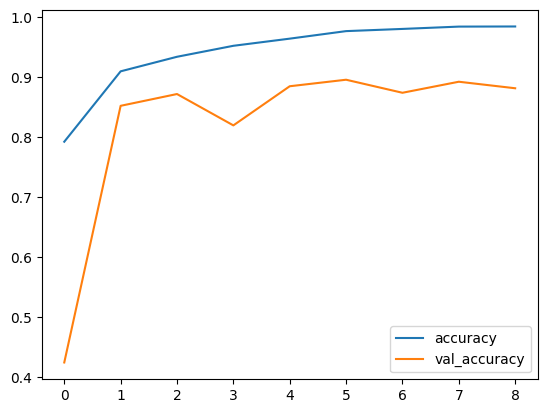

In [88]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()
plt.show()